In [59]:
# Preprocessing reddit data for sentiment analysis (Capstone 1)
# import necessary libraries
# Might want to pull a different dataset using Reddit API/praw
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re    # RegEx (remove non-letter characters)
import nltk  # natural language processing toolkit
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from IPython import display
import math
from pprint import pprint
# Modeling
from sklearn.model_selection import train_test_split
# import tensorflow as tf # Python 3.8 does not support tensorflow
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
# Data visualization
import matplotlib.patches as mpatches
%matplotlib inline

# pd.options.plotting.backend = "plotly"
# from library.sb_utils import save_file
# ref: https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/
# red = pd.read_csv('Reddit_data.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hillarylevinson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Dataset:
red = pd.read_csv('Reddit_data.csv')

In [69]:
# New dataset? Using Reddit API/praw:
# Created app on Reddit, now praw:
#import praw
# ! pip3 install --upgrade git+https://github.com/praw-dev/praw.git

  Cloning https://github.com/praw-dev/praw.git to /private/var/folders/7l/yq5kkkk111db74sclsqc7vnr0000gn/T/pip-rQmusT-build
praw requires Python '~=3.6' but the running Python is 2.7.13


In [67]:
# praw install, cont.
#reddit = praw.Reddit(client_id='e3-Db8LuPKSCYQ',
#                     client_secret='RnvTdu2n9k_ORLc787MSH5amhKGNDw',
#                     user_agent='reddit_scraper_by_HLDsent')

NameError: name 'praw' is not defined

In [2]:
# print first 5 rows:
red.head()
# For category column, 1 = positive, 0 = neutral, -1 = negative sentiments

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [3]:
red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [4]:
# number of missing values by column
# missing = pd.concat([red.isnull().sum(), 100 * red.isnull().mean()], axis=1)
# missing.columns=['count', '%']
# missing.sort_values(by='count')

In [5]:
red.isnull().sum()

clean_comment    100
category           0
dtype: int64

In [6]:
# clean up empty cells
red.dropna(axis=0, inplace=True)

In [7]:
red.isnull().sum()

clean_comment    0
category         0
dtype: int64

In [8]:
red.shape

(37149, 2)

In [9]:
# Map comment categories
red['category'] = red['category'].map({-1:'Negative', 0:'Neutral', 1:'Positive'})
# Output first five rows
red.head()

,clean_comment,category
0,family mormon have never tried explain them t...,Positive
1,buddhism has very much lot compatible with chr...,Positive
2,seriously don say thing first all they won get...,Negative
3,what you have learned yours and only yours wha...,Neutral
4,for your own benefit you may want read living ...,Positive


<AxesSubplot:xlabel='category'>

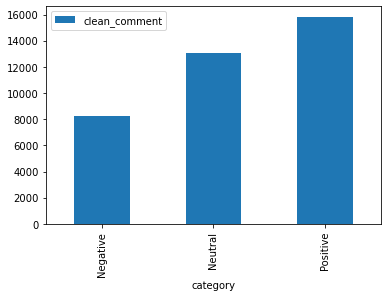

In [10]:
# Visualize
red.groupby('category').count().plot(kind='bar')

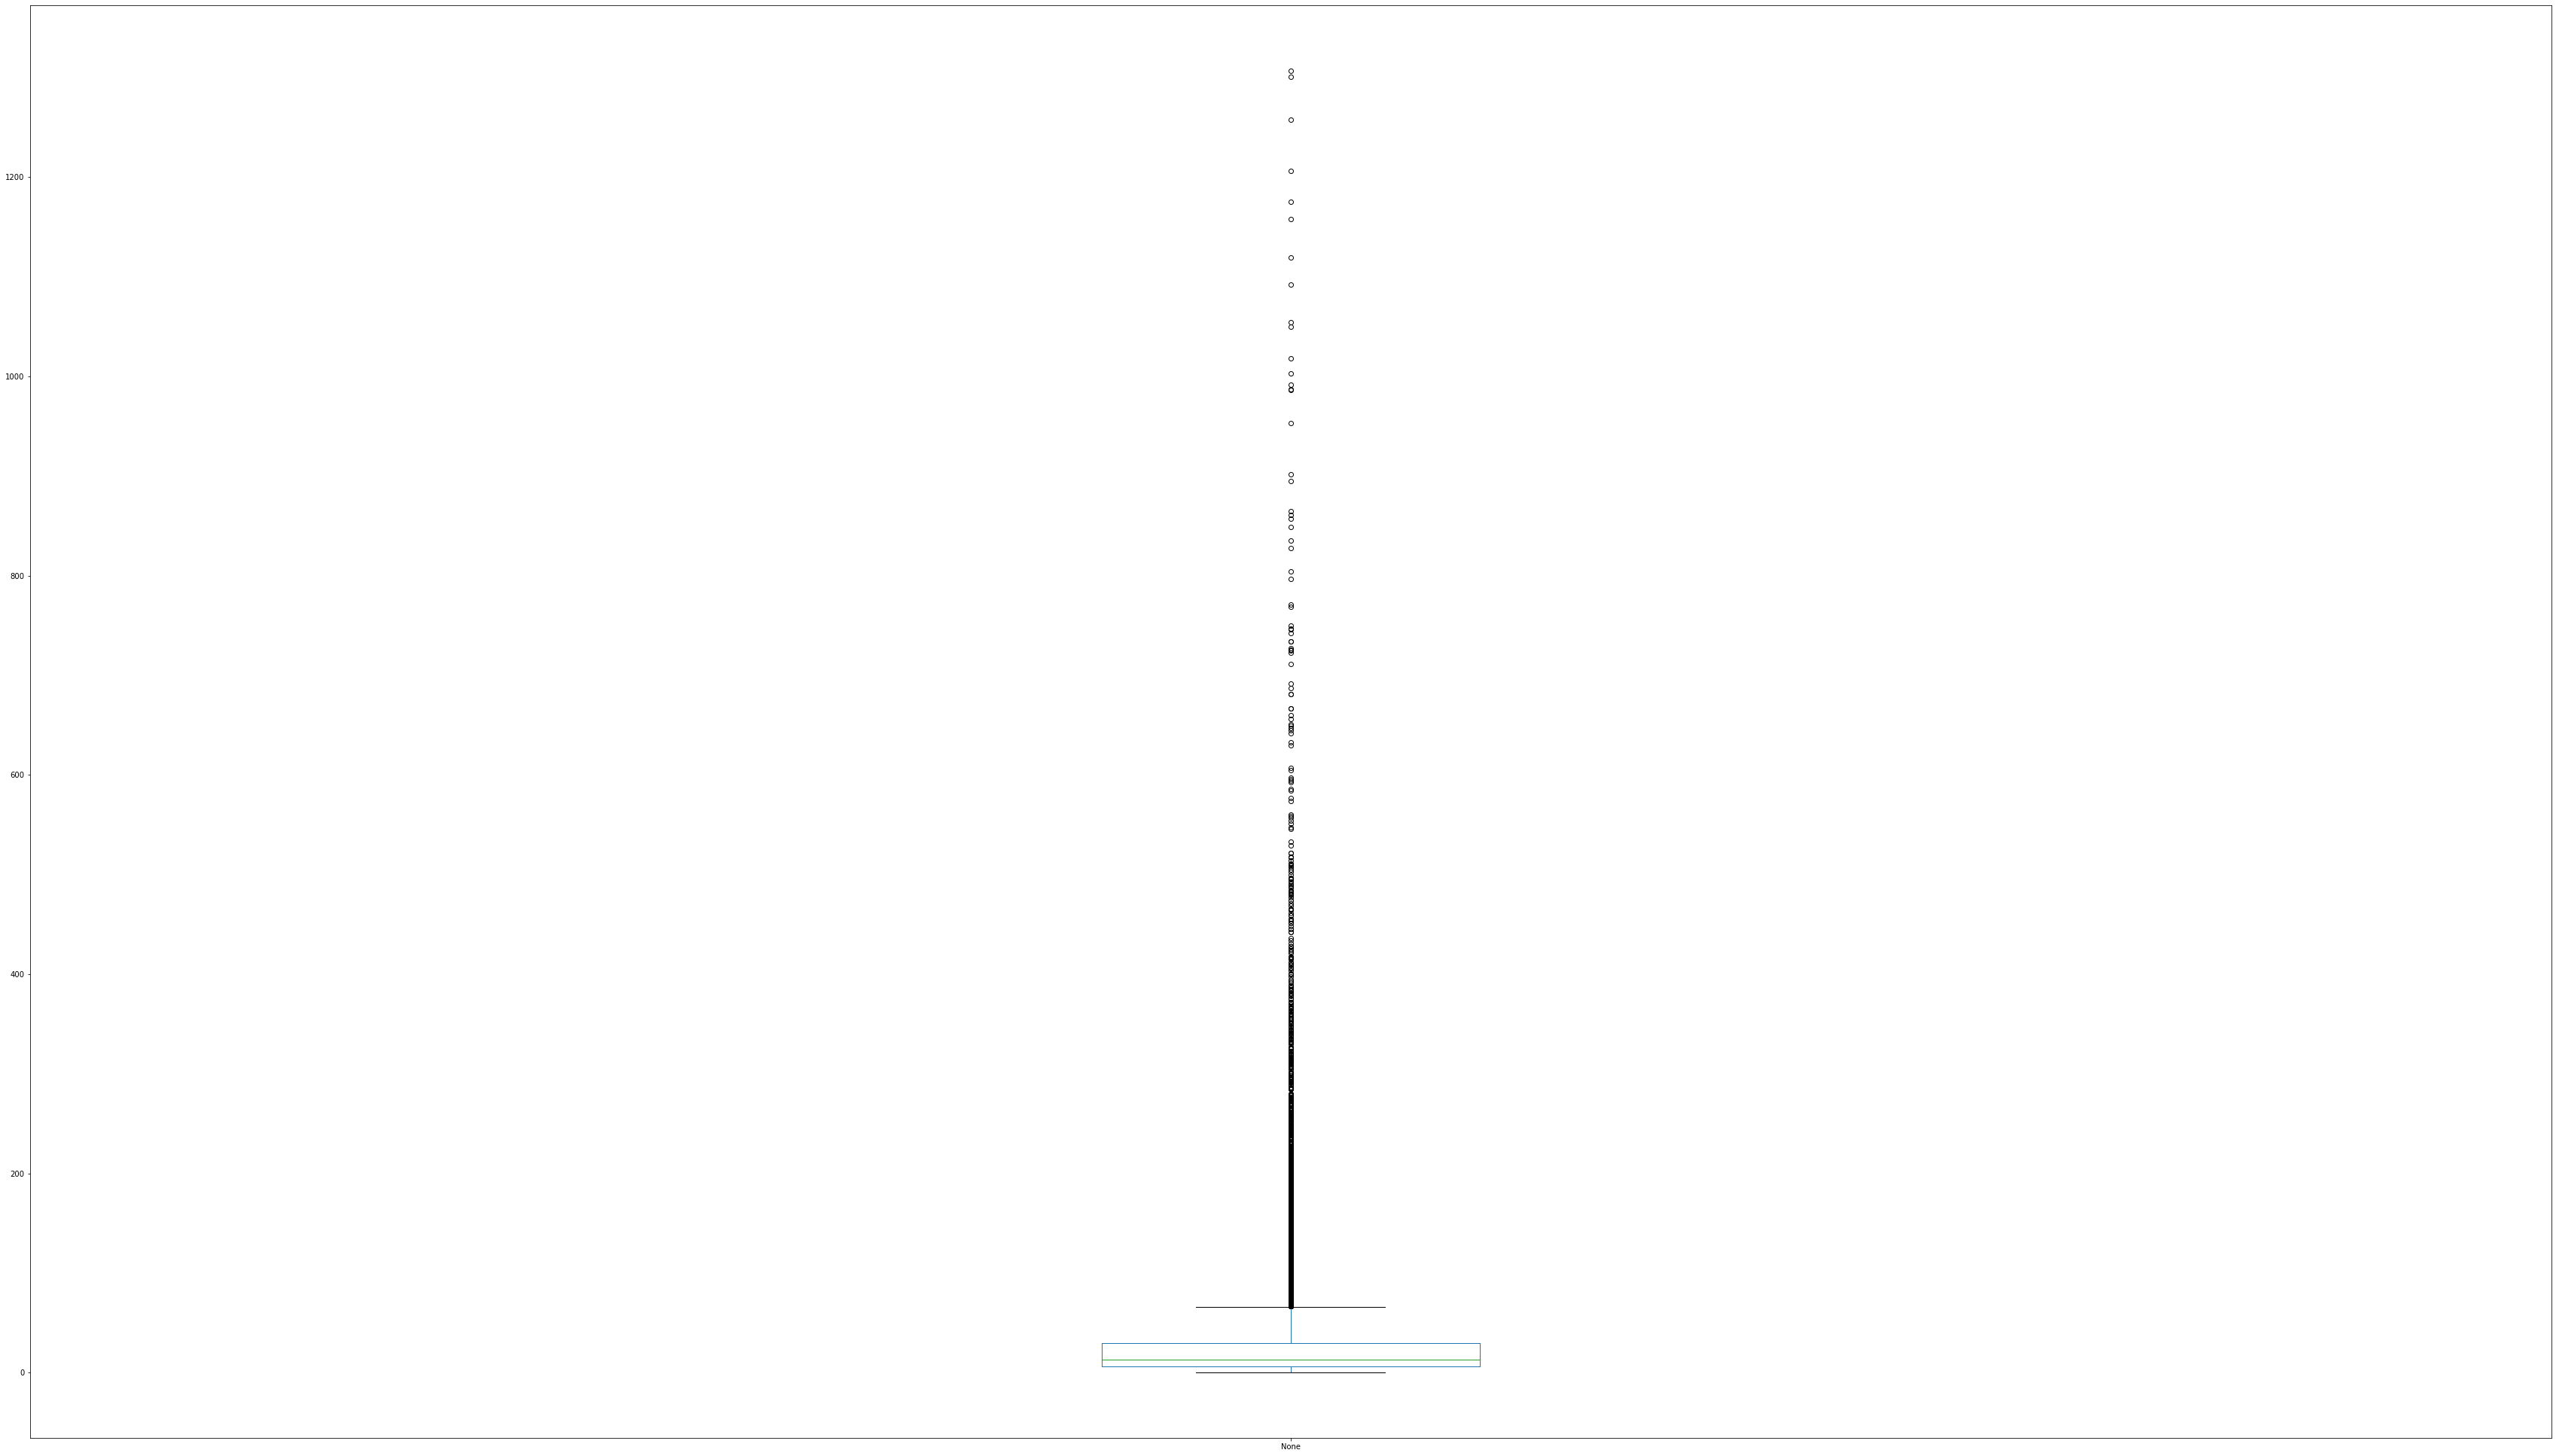

In [11]:
# Calculate comment lengths
com_len = pd.Series([len(com.split()) for com in red['clean_comment']])

# The distribution of tweet text lengths
fig = com_len.plot(kind='box', figsize=(60,35))

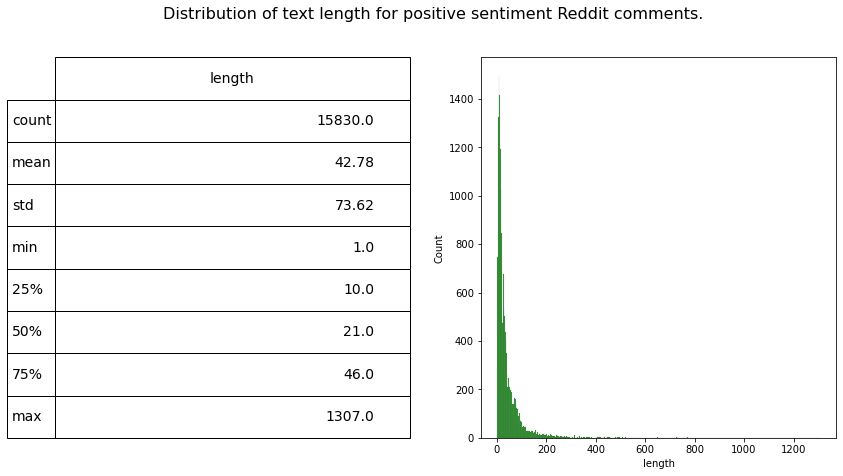

In [12]:
# Plotting positive sentiment comments
fig = plt.figure(figsize=(14,7))
red['length'] = red.clean_comment.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(red[red['category']=='Positive']['length'], ax=ax1,color='green')
describe = red.length[red.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment Reddit comments.', fontsize=16)

plt.show()

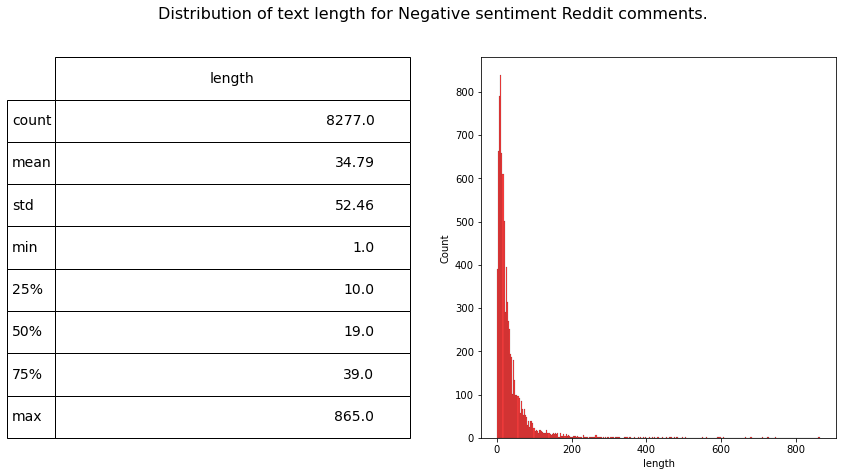

In [13]:
# Plotting negative sentiment comments
fig = plt.figure(figsize=(14,7))
red['length'] = red.clean_comment.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(red[red['category']=='Negative']['length'], ax=ax1,color='red')
describe = red.length[red.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment Reddit comments.', fontsize=16)

plt.show()

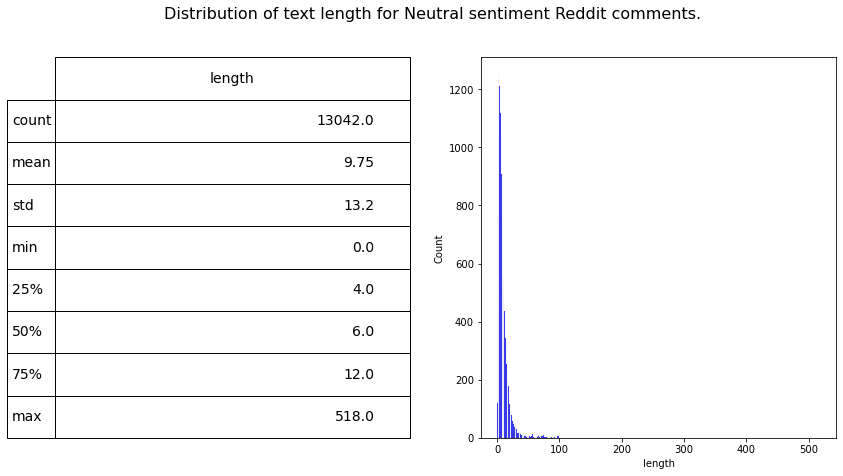

In [14]:
# Plotting neutral sentiment comments
fig = plt.figure(figsize=(14,7))
red['length'] = red.clean_comment.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(red[red['category']=='Neutral']['length'], ax=ax1,color='blue')
describe = red.length[red.category=='Neutral'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Neutral sentiment Reddit comments.', fontsize=16)

plt.show()

In [16]:
# Positive group:
posred = red[red['category']=='Positive']

In [17]:
posred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15830 entries, 0 to 37247
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  15830 non-null  object
 1   category       15830 non-null  object
 2   length         15830 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 494.7+ KB


In [24]:
# Just the comments column for whole dataset
redcom = red["clean_comment"]

In [25]:
redcom.head()

0     family mormon have never tried explain them t...
1    buddhism has very much lot compatible with chr...
2    seriously don say thing first all they won get...
3    what you have learned yours and only yours wha...
4    for your own benefit you may want read living ...
Name: clean_comment, dtype: object

In [37]:
# Ge scores from NLTK and compare:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in redcom:
    pol_score = sia.polarity_scores(line)
    pol_score['comment'] = line
    results.append(pol_score)

pprint(results[:3], width=100)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hillarylevinson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[{'comment': ' family mormon have never tried explain them they still stare puzzled from time time '
             'like some kind strange creature nonetheless they have come admire for the patience '
             'calmness equanimity acceptance and compassion have developed all the things buddhism '
             'teaches ',
  'compound': 0.9349,
  'neg': 0.067,
  'neu': 0.594,
  'pos': 0.339},
 {'comment': 'buddhism has very much lot compatible with christianity especially considering that '
             'sin and suffering are almost the same thing suffering caused wanting things shouldn '
             'want going about getting things the wrong way christian this would mean wanting '
             'things that don coincide with god will and wanting things that coincide but without '
             'the aid jesus buddhism could also seen proof god all mighty will and omnipotence '
             'certainly christians are lucky have one such christ there side but what about '
             'ev

In [38]:
# Create dataframe of SIA results:
df = pd.DataFrame.from_records(results)
df.head()

,neg,neu,pos,compound,comment
0,0.067,0.594,0.339,0.9349,family mormon have never tried explain them t...
1,0.066,0.653,0.280,0.9953,buddhism has very much lot compatible with chr...
2,0.035,0.825,0.140,0.8750,seriously don say thing first all they won get...
3,0.000,0.956,0.044,0.0772,what you have learned yours and only yours wha...
4,0.102,0.704,0.194,0.8907,for your own benefit you may want read living ...


In [39]:
# create new labels from SIA:
df['label'] = 0
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < -0.2, 'label'] = -1
df.head()

,neg,neu,pos,compound,comment,label
0,0.067,0.594,0.339,0.9349,family mormon have never tried explain them t...,1
1,0.066,0.653,0.280,0.9953,buddhism has very much lot compatible with chr...,1
2,0.035,0.825,0.140,0.8750,seriously don say thing first all they won get...,1
3,0.000,0.956,0.044,0.0772,what you have learned yours and only yours wha...,0
4,0.102,0.704,0.194,0.8907,for your own benefit you may want read living ...,1


In [40]:
df2 = df[['comment', 'label']]
df2.to_csv('reddit_SIA_comment_labels.csv', mode='a', encoding='utf-8', index=False)

In [41]:
# Glimpse of new labels:
print("Positive comments:\n")
pprint(list(df[df['label'] == 1].comment)[:5], width=200)

print("\nNegative comments:\n")
pprint(list(df[df['label'] == -1].comment)[:5], width=200)

print("\nNeutral comments:\n")
pprint(list(df[df['label'] == 0].comment)[:5], width=200)

Positive comments:

[' family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity '
 'acceptance and compassion have developed all the things buddhism teaches ',
 'buddhism has very much lot compatible with christianity especially considering that sin and suffering are almost the same thing suffering caused wanting things shouldn want going about getting '
 'things the wrong way christian this would mean wanting things that don coincide with god will and wanting things that coincide but without the aid jesus buddhism could also seen proof god all '
 'mighty will and omnipotence certainly christians are lucky have one such christ there side but what about everyone else well many christians believe god grace salvation and buddhism god way '
 'showing grace upon others would also help study the things jesus said and see how buddha has made similar claims such ric

In [42]:
# How many of each category we have with new SIA labels:
print(df.label.value_counts())

print(df.label.value_counts(normalize=True) * 100)

 1    14075
 0    13379
-1     9695
Name: label, dtype: int64
 1    37.887965
 0    36.014428
-1    26.097607
Name: label, dtype: float64


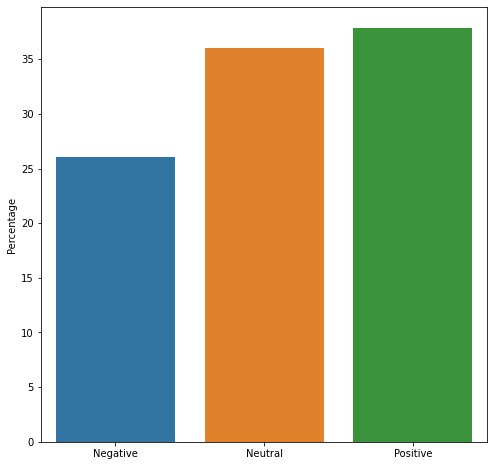

In [43]:
# Bar chart of SIA categories
fig, ax = plt.subplots(figsize=(8, 8))

counts = df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [48]:
# Prepare to tokenize:
from nltk.tokenize import word_tokenize, RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(stop_words[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [49]:
# Create a function that will read a list of comments and perform lowercasing, tokenizing, and stopword removal:
def process_text(redcom):
    tokens = []
    for line in redcom:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37149 entries, 0 to 37148
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   neg       37149 non-null  float64
 1   neu       37149 non-null  float64
 2   pos       37149 non-null  float64
 3   compound  37149 non-null  float64
 4   comment   37149 non-null  object 
 5   label     37149 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.7+ MB


In [ ]:
df['comment'].str.len().hist()

In [51]:
# Most common words in positive comments:

pos_lines = list(df[df.label == 1].comment)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(20)

[('like', 3193),
 ('people', 2637),
 ('good', 2578),
 ('india', 2485),
 ('bjp', 2370),
 ('modi', 2302),
 ('one', 1918),
 ('would', 1720),
 ('even', 1412),
 ('get', 1304),
 ('think', 1282),
 ('well', 1238),
 ('party', 1231),
 ('time', 1207),
 ('congress', 1203),
 ('also', 1191),
 ('best', 1021),
 ('know', 1010),
 ('see', 1007),
 ('free', 970)]

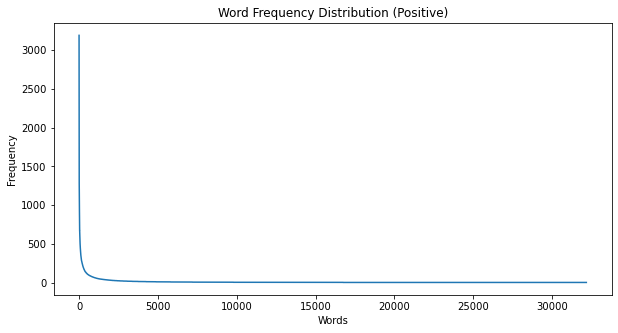

In [52]:
# Word frequency distribution of most common positive comment words:

y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

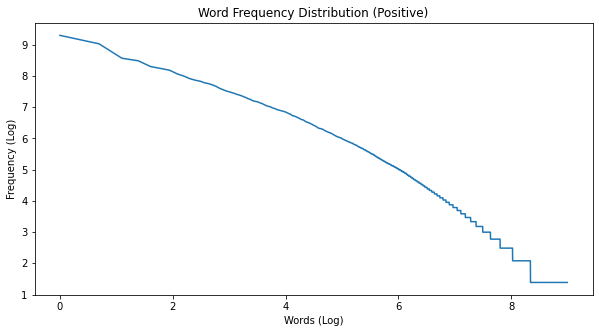

In [53]:
# Log transformation of word frequency (positive words):
y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Positive)")
plt.plot(x_val, y_final)
plt.show()

In [55]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37149 entries, 0 to 37148
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  37149 non-null  object
 1   label    37149 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 580.6+ KB


In [56]:
df2.head()

,comment,label
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [73]:
# Same thing, but for negative comment words:
neg_lines = list(df2[df2.label == -1].comment)

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(20)

[('people', 2229),
 ('india', 1926),
 ('bjp', 1817),
 ('modi', 1721),
 ('like', 1374),
 ('one', 1198),
 ('even', 1089),
 ('would', 1035),
 ('get', 1030),
 ('government', 849),
 ('indian', 768),
 ('country', 743),
 ('think', 731),
 ('time', 724),
 ('congress', 709),
 ('also', 708),
 ('shit', 707),
 ('pakistan', 702),
 ('fuck', 682),
 ('way', 656)]

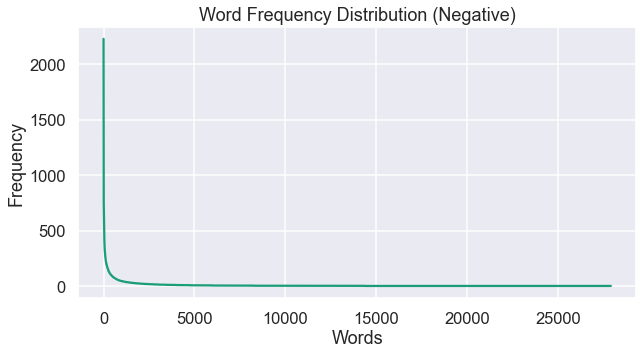

In [74]:
# Word frequency graph for most common negative comment words (many similar as positive):
y_val = [x[1] for x in neg_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

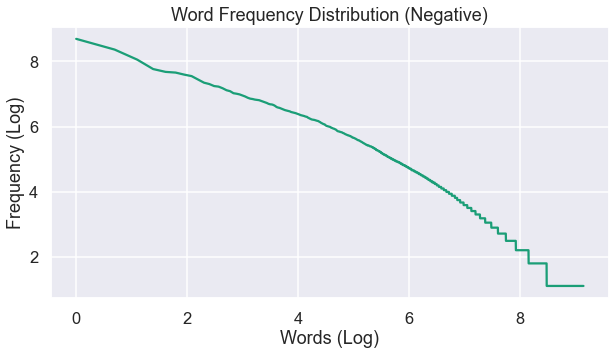

In [75]:
# Log transformation of word frequency for negative comment words:
y_final = []
for i, k, z in zip(y_val[0::3], y_val[1::3], y_val[2::3]):
    if i + k + z == 0:
        break
    y_final.append(math.log(i + k + z))

x_val = [math.log(i+1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Negative)")
plt.plot(x_val, y_final)
plt.show()

In [76]:
# Same thing, but for neutral comments:
neu_lines = list(df2[df2.label == 0].comment)

neu_tokens = process_text(neu_lines)
neu_freq = nltk.FreqDist(neu_tokens)

neu_freq.most_common(20)

[('modi', 984),
 ('bjp', 900),
 ('india', 878),
 ('people', 691),
 ('one', 662),
 ('hai', 539),
 ('like', 481),
 ('time', 467),
 ('would', 463),
 ('lot', 460),
 ('think', 440),
 ('get', 439),
 ('congress', 390),
 ('even', 364),
 ('know', 359),
 ('see', 347),
 ('right', 346),
 ('indian', 324),
 ('going', 298),
 ('also', 293)]

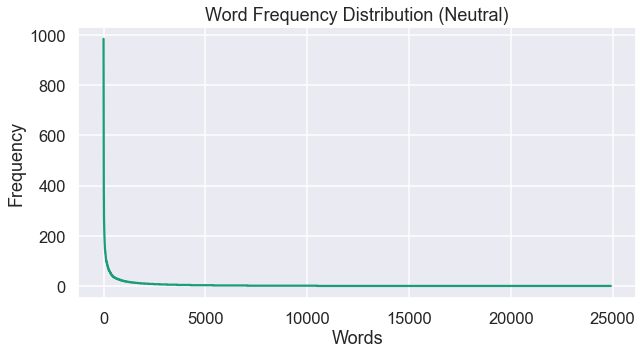

In [80]:
y_val = [x[1] for x in neu_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Neutral)")
plt.show()

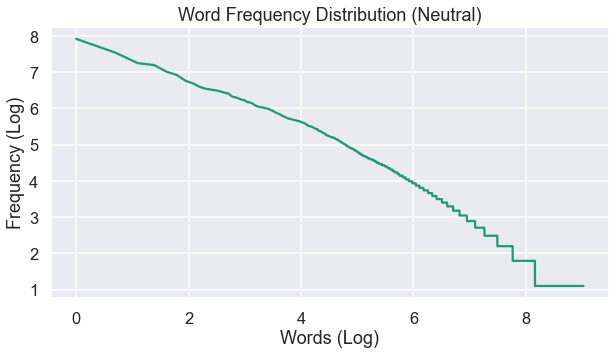

In [81]:
# Log transformation of word frequency for neutral comment words:
y_final = []
for i, k, z in zip(y_val[0::3], y_val[1::3], y_val[2::3]):
    if i + k + z == 0:
        break
    y_final.append(math.log(i + k + z))

x_val = [math.log(i+1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Neutral)")
plt.plot(x_val, y_final)
plt.show()

In [85]:
# POS tagging
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from nltk import RegexpParser

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hillarylevinson/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[(' family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches ',
  'JJ'),
 ('buddhism has very much lot compatible with christianity especially considering that sin and suffering are almost the same thing suffering caused wanting things shouldn want going about getting things the wrong way christian this would mean wanting things that don coincide with god will and wanting things that coincide but without the aid jesus buddhism could also seen proof god all mighty will and omnipotence certainly christians are lucky have one such christ there side but what about everyone else well many christians believe god grace salvation and buddhism god way showing grace upon others would also help study the things jesus said and see how buddha has made similar claims such rich man getting into heaven

In [98]:
# POS tagging - all words
all_lines = list(df.comment)
alltokens = process_text(all_lines)
alltags = nltk.pos_tag(alltokens)
from collections import Counter
allcounts = Counter( tag for word, tag in alltags)
print(allcounts)

Counter({'NN': 263806, 'JJ': 136779, 'NNS': 78812, 'RB': 45575, 'VBP': 41893, 'VBG': 30826, 'VBD': 29262, 'VB': 17536, 'VBN': 16507, 'IN': 15305, 'CD': 13279, 'VBZ': 13030, 'MD': 6616, 'JJS': 3008, 'JJR': 2523, 'DT': 2199, 'FW': 1850, 'RBR': 1728, 'NNP': 1438, 'CC': 668, 'RP': 545, 'WDT': 335, 'PRP': 164, 'RBS': 153, 'WP': 133, 'WRB': 132, 'UH': 129, 'WP$': 99, 'NNPS': 42, '$': 41, 'EX': 10, 'PRP$': 6, 'POS': 5, 'PDT': 1})


In [112]:
# Create dataframe of POS tags:
from nltk import word_tokenize, pos_tag, pos_tag_sents
nltk.download('punkt')
texts = df['comment'].tolist()
tagged_texts = pos_tag_sents(map(word_tokenize, texts))
tagged_texts

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hillarylevinson/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[[('family', 'NN'),
  ('mormon', 'NNS'),
  ('have', 'VBP'),
  ('never', 'RB'),
  ('tried', 'VBN'),
  ('explain', 'VBP'),
  ('them', 'PRP'),
  ('they', 'PRP'),
  ('still', 'RB'),
  ('stare', 'VBP'),
  ('puzzled', 'VBN'),
  ('from', 'IN'),
  ('time', 'NN'),
  ('time', 'NN'),
  ('like', 'IN'),
  ('some', 'DT'),
  ('kind', 'NN'),
  ('strange', 'JJ'),
  ('creature', 'NN'),
  ('nonetheless', 'RB'),
  ('they', 'PRP'),
  ('have', 'VBP'),
  ('come', 'VBN'),
  ('admire', 'NN'),
  ('for', 'IN'),
  ('the', 'DT'),
  ('patience', 'NN'),
  ('calmness', 'NN'),
  ('equanimity', 'NN'),
  ('acceptance', 'NN'),
  ('and', 'CC'),
  ('compassion', 'NN'),
  ('have', 'VBP'),
  ('developed', 'VBN'),
  ('all', 'PDT'),
  ('the', 'DT'),
  ('things', 'NNS'),
  ('buddhism', 'NN'),
  ('teaches', 'NNS')],
 [('buddhism', 'NN'),
  ('has', 'VBZ'),
  ('very', 'RB'),
  ('much', 'JJ'),
  ('lot', 'NN'),
  ('compatible', 'JJ'),
  ('with', 'IN'),
  ('christianity', 'NN'),
  ('especially', 'RB'),
  ('considering', 'VBG'),
  ('t

In [113]:
# Create dataframe of POS tags cont.
df['POS'] = tagged_texts

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37149 entries, 0 to 37148
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   neg       37149 non-null  float64
 1   neu       37149 non-null  float64
 2   pos       37149 non-null  float64
 3   compound  37149 non-null  float64
 4   comment   37149 non-null  object 
 5   label     37149 non-null  int64  
 6   POS       37149 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 2.0+ MB


In [115]:
df.head(20)

,neg,neu,pos,compound,comment,label,POS
0,0.067,0.594,0.339,0.9349,family mormon have never tried explain them t...,1,"[(family, NN), (mormon, NNS), (have, VBP), (ne..."
1,0.066,0.653,0.280,0.9953,buddhism has very much lot compatible with chr...,1,"[(buddhism, NN), (has, VBZ), (very, RB), (much..."
2,0.035,0.825,0.140,0.8750,seriously don say thing first all they won get...,1,"[(seriously, RB), (don, NNS), (say, VBP), (thi..."
3,0.000,0.956,0.044,0.0772,what you have learned yours and only yours wha...,0,"[(what, WP), (you, PRP), (have, VBP), (learned..."
4,0.102,0.704,0.194,0.8907,for your own benefit you may want read living ...,1,"[(for, IN), (your, PRP$), (own, JJ), (benefit,..."
5,0.000,0.898,0.102,0.3626,you should all sit down together and watch the...,1,"[(you, PRP), (should, MD), (all, VB), (sit, VB..."
6,0.041,0.756,0.203,0.9806,was teens when discovered zen meditation was ...,1,"[(was, VBD), (teens, NNS), (when, WRB), (disco..."
7,0.000,1.000,0.000,0.0000,jesus was zen meets jew,0,"[(jesus, NN), (was, VBD), (zen, JJ), (meets, N..."
8,0.073,0.755,0.172,0.8625,there are two varieties christians dogmatic th...,1,"[(there, EX), (are, VBP), (two, CD), (varietie..."
9,0.040,0.804,0.155,0.6131,dont worry about trying explain yourself just ...,1,"[(dont, NN), (worry, VBP), (about, IN), (tryin..."


In [91]:
# POS tagging - positive words
pos_lines = list(df[df.label == 1].comment)
pos_tokens = process_text(pos_lines)
postags = nltk.pos_tag(pos_tokens)
# from collections import Counter
poscounts = Counter( tag for word,  tag in postags)
print(poscounts)

Counter({'NN': 121443, 'JJ': 67835, 'NNS': 38904, 'RB': 23704, 'VBP': 20523, 'VBG': 14777, 'VBD': 13320, 'VB': 9228, 'IN': 7936, 'VBN': 7838, 'CD': 6535, 'VBZ': 6320, 'MD': 3534, 'JJS': 1900, 'JJR': 1356, 'DT': 1079, 'RBR': 1039, 'FW': 667, 'NNP': 403, 'CC': 320, 'RP': 253, 'WDT': 168, 'RBS': 105, 'PRP': 87, 'UH': 85, 'WRB': 61, 'WP$': 50, 'WP': 46, 'NNPS': 20, '$': 18, 'PRP$': 7, 'EX': 4, 'POS': 3})


AttributeError: 'Counter' object has no attribute 'index'

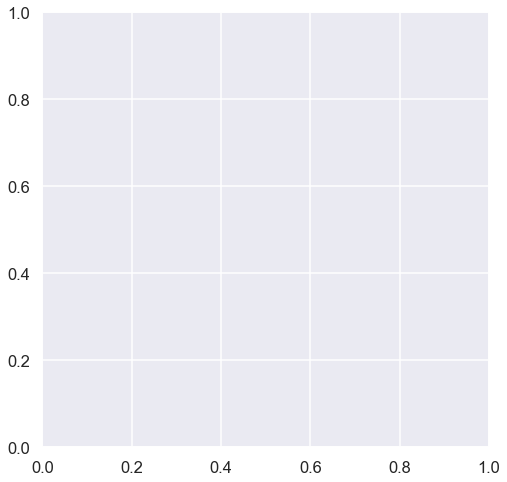

In [100]:
# Bar chart of POS for positive words
fig, ax = plt.subplots(figsize=(8, 8))


dfpos = 
#counts = poscounts(normalize=True) * 100

sns.barplot(x=poscounts.index, y=poscounts, ax=ax)

#ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [92]:
# POS tagging - negative words
neg_lines = list(df[df.label == -1].comment)
neg_tokens = process_text(neg_lines)
negtags = nltk.pos_tag(neg_tokens)
negcounts = Counter( tag for word,  tag in negtags)
print(negcounts)

Counter({'NN': 89697, 'JJ': 47286, 'NNS': 28503, 'RB': 15327, 'VBP': 14391, 'VBD': 11475, 'VBG': 11407, 'VBN': 6275, 'VB': 5676, 'IN': 5075, 'VBZ': 4543, 'CD': 4224, 'MD': 2101, 'JJR': 862, 'DT': 801, 'JJS': 745, 'FW': 697, 'RBR': 486, 'NNP': 357, 'CC': 225, 'RP': 209, 'WDT': 122, 'WP': 51, 'WRB': 47, 'PRP': 44, 'WP$': 38, 'UH': 35, 'RBS': 27, '$': 13, 'NNPS': 13, 'EX': 4, 'POS': 2, 'PDT': 1})


In [93]:
# POS tagging - neutral words
# neu_lines = list(df[df.label == 0].comment)
# neu_tokens = process_text(neu_lines)
neutags = nltk.pos_tag(neu_tokens)
neucounts = Counter( tag for word,  tag in neutags)
print(neucounts)

Counter({'NN': 52743, 'JJ': 21592, 'NNS': 11415, 'VBP': 7003, 'RB': 6549, 'VBG': 4644, 'VBD': 4443, 'VB': 2618, 'CD': 2523, 'VBN': 2402, 'IN': 2289, 'VBZ': 2160, 'MD': 972, 'NNP': 687, 'FW': 479, 'JJS': 384, 'DT': 313, 'JJR': 298, 'RBR': 208, 'CC': 115, 'RP': 89, 'WDT': 46, 'WP': 33, 'PRP': 24, 'WRB': 20, 'UH': 18, 'RBS': 11, 'WP$': 11, '$': 9, 'NNPS': 7, 'PRP$': 2, 'EX': 1})


In [ ]:
print(df.label.value_counts())

print(df.label.value_counts(normalize=True) * 100)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()